In [1]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML, Image
from scipy.stats import ttest_ind_from_stats, spearmanr
from sklearn.preprocessing import StandardScaler
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import xlsxwriter 
import tqdm
import math
import xarray as xr
from scipy.special import softmax
import torch
%matplotlib inline
from torch.autograd import Variable


In [2]:
torch.__version__

'1.10.0'

# Model definition 

In [30]:
class BinaryTS:
    
    def __init__(self,d=10, A=None, B=None, sigma=None,R=10000):
        
        """
        Instanciates the binaryTS model. 
        
        Arguments: 
        
        - d: dimension of the model. 
        - A: (d,d) matrix that controls the dynamics related to the observed state. 
        - B: (d,d) matrix that controls the dynamics related to the latent state. 
        - sigma: (d,d) positive definite matrix that controls the variance of the noise. 
        - R: number of MCMC samples for expectation approximations used in VEM. 
        
        By default, the BinaryTS model is instanciated with random matrices A, B and sigma. You can provide your 
        own, but B should have all its eigenvalues of module less than 1 in order to enforce stability of the model
        (see companion paper for further information). 
        
        """
        
        self.d = d
        
        if A is None:
            self.A = 2*np.identity(d) + 0.1*np.random.randn(d,d)
        else: 
            self.A = A
            
        if B is None:     
            random_eig = np.random.uniform(low=-0.7,high=0.7,size=d) 
            self.B = np.diag(random_eig) 
        else:
            self.B = B

        self.eig_B = np.abs((np.linalg.eig(self.B)[0]))
        
        random_matrix = np.random.randn(d,d)
        self.sigma = 7*np.dot(random_matrix,random_matrix.T)
        self.sigma_inv = np.linalg.inv(self.sigma)
        self.data = None
        self.R = 1000
        
        
    ### Util functions###
    
    def sample(self,N=100,T=100,fixdata=True):
        
        """
        Samples N samles over T timesteps from the DGP. If fixdata is set to True, sampled x data is saved in 
        an attribute called self.data, along with (N,T) used for sampling in self.N and self.T. 
        """
        
        x_data = np.zeros((N,self.d,T))
        z_data = np.zeros((N,self.d,T))
        p_data = np.zeros((N,self.d,T))
        
        self.x0 = np.random.randint(0,2,size=(self.d,N))
        self.z0 = np.random.randn(self.d,N)
        
        x = self.x0
        z = self.z0
        
        x_data[:,:,0] = self.x0.T
        z_data[:,:,0] = self.z0.T
        p_data[:,:,0] = 1/2*np.ones((N,self.d))
        
        for t in np.arange(1,T): 
            z = self.A@x + self.B@z + np.random.multivariate_normal(mean=np.zeros(self.d),cov=self.sigma,size=N).T
            p = softmax(z,axis=0)
            x = np.random.binomial(1,p,size=(self.d,N))
            x_data[:,:,t] = x.T
            z_data[:,:,t] = z.T
            p_data[:,:,t] = p.T
            
        if fixdata: 
            self.data = x_data
            self.N = N
            self.T = T
        
        return x_data,z_data,p_data
    
    def snapshot(self,N,T,x_data=None,z_data=None,p_data=None,pltdim = 3,plttime=500,save=False): 
        
        """
        Generates and plots some data from the data generating process. This method displayes three components 
        of the DGP for every dimension: 
        - the observed, 0-1 valued process
        - the latent state
        - the probability associated to the current latent state obtained through softmaxification. 
        
        Arguments:
        
        - N: number of individuals (for plotting, one is choosen at random).
        - T: number of timesteps over which data is generated. 
        - x_data, z_data, p_data: allows to pass previously generate data for plotting (instead of 
        generating new observations).
        - pltdim: number of dimensions plotted. 
        - plttime: number of timesteps plotted. 
        - save: if set to True, a .pdf of the generated image is saved. 
        """
        
        if x_data is None and z_data is None and p_data is None: 
            x_data,z_data,p_data = self.sample(N=N,T=T,fixdata=False)
            
        plttime = np.minimum(T,plttime)
        pltdim = np.minimum(pltdim,self.d)
        random_ind = np.random.randint(0,N)
        
        sns.set_context('talk')
        sns.set_style('white')
            
        f,ax=plt.subplots(pltdim,3,figsize=(pltdim*25,pltdim*10))
        
        for i in np.arange(pltdim):
        
            ax[i,0].plot(x_data[random_ind,i,:plttime],c='orange')
            ax[i,1].plot(z_data[random_ind,i,:plttime],c='red')
            ax[i,2].plot(p_data[random_ind,i,:plttime],c='green')
                        
            ax[i,0].set_yticks([0,1])
            
            for a in ['left','bottom']:
            
                ax[i,0].spines[a].set_linewidth(2.5)
                ax[i,1].spines[a].set_linewidth(2.5)
                ax[i,2].spines[a].set_linewidth(2.5)
            
            for j in [0,1,2]:
                ax[i,j].spines["right"].set_visible(False)
                ax[i,j].spines["top"].set_visible(False)
        
        
        plt.tight_layout()
        
        if save: 
            
            plt.savefig('snapshot.pdf')
    
    
    ### Functions for VEM ###
    
    def compute_precision(self,B): 
        
        """
        Computes the precision matrix, starting from the Cholesky decomposition. 
        
        Arguments:
            - B: (d,T,T) tensor, where (i,:,:) is the Cholesky decomposition of the i-th precision matrix.
        """
        
        return B.T@B
    
    def compute_covmat(self,B): 
        
        """
        Computes the variance-covariance matrix, starting from the Cholesky decomposition, in a differentiable way.
        
        Arguments: 
            - B: (d,T,T) tensor, where (i,:,:) is the Cholesky decomposition of the i-th precision matrix.   
        """
        
        return torch.linalg.inv(B.T@B)
    
    def check_data(self):
        
        if self.data is None: 
            raise ValueError('self.data is empty. Use self.sample(args,fixdata=True) to sample some data first.')
            
    def full_log_expectation(self,var): 
    
        """
        Approximates the expectation w.r.t. to the variational density of log sum_{all terms} exp in the ELBO term. 
        Handles overflow problems through max regularization. 
        Returns a scalar. 

        """
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R

        mu = var[0:d]
        sigmas = var[d:]

        draw = torch.randn(self.d,self.R)
        transformed_draw = draw*(torch.tile(sigmas,(R,1)).T) + torch.tile(mu,(R,1)).T
        log_approx = torch.logsumexp(transformed_draw,0)
        log_approx = log_approx.mean()

        return log_approx 
    
    def partial_log_expectation(self,var):
    
        """
        Approximates the expectation w.r.t. to the variational density of the log sum_{all but i} exp terms 
        in the ELBO term. 
        Returns a  (d,) array whose i-th term corresponds to the expectation of log sum_{all but i} exp.

        """
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R

        mu = var[0:d]
        sigmas = var[d:]

        draw = torch.randn(d,d-1,self.R)
        partial_log_sum = torch.zeros(d)

        for i in np.arange(d):
            mask = [k for k in np.arange(d) if k != i]
            transformed_draw = draw[i,:,:]*(torch.tile(sigmas[mask],(R,1)).T) + torch.tile(mu[mask],(R,1)).T
            log_approx = torch.logsumexp(transformed_draw,0)
            log_approx = log_approx.mean()
            partial_log_sum[i] = log_approx 

        return partial_log_sum
    
    def compute_bilinear_term(self,mu_approx,cov_approx,A,B,sigma):
        
        self.check_data()
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R
        
        if B is None: 
            B = self.B
            B = Variable(torch.from_numpy(B)).type(torch.FloatTensor)
        
        if A is None:
            A = self.A
            A = Variable(torch.from_numpy(A)).type(torch.FloatTensor)
            
        if sigma is None: 
            sigma = self.sigma
            sigma = Variable(torch.from_numpy(sigma)).type(torch.FloatTensor)
        
        data = Variable(torch.from_numpy(self.data).type(torch.FloatTensor))
        
        sigma_inv = Variable(torch.from_numpy(self.sigma_inv).type(torch.FloatTensor))
        
        return torch.trace((mu_approx.T)@sigma_inv@mu_approx)    
        
    
    def compute_elbo(self,mu_approx,var_approx,A=None,B=None,sigma=None):
        
        """
        Returns the Evidence Lower Bound (ELBO) of the model, normalized by 1/(N*T).  
        
        Arguments:
        - mu_approx: (d,T+1) tensor. Expectations of the variational density.   
        - var_approx: (d,T,T) tensor. Cholesky decomposition of the precision matrix. Reconstruction
        of the precision matrix is enabled by self.compute_precision(var_approx). 
        - B: (d,d) matrix for ELBO evaluation. If None, the true A matrix of the model is used.
        - sigma: (d,d) positive definite matrix for ELBO evaluation. 
        If None, the true A matrix of the model is used.
        
        """
        
        self.check_data()
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R
        
        if B is None: 
            B = self.B
            B = Variable(torch.from_numpy(B)).type(torch.FloatTensor)
        
        if A is None:
            A = self.A
            A = Variable(torch.from_numpy(A)).type(torch.FloatTensor)
            
        if sigma is None: 
            sigma = self.sigma
            sigma = Variable(torch.from_numpy(sigma)).type(torch.FloatTensor)
        
        data = Variable(torch.from_numpy(self.data).type(torch.FloatTensor))
        
        sigma_inv = Variable(torch.from_numpy(self.sigma_inv).type(torch.FloatTensor))
        
        
        
        variational_entropy = 2*sum([torch.trace(torch.log(var_approx)[i,:,:]) for i in np.arange(d)])

        entropy = -(T/2)*torch.logdet(sigma)

        full_log_approx = self.full_log_expectation(var)
        
        partial_log_approx = (self.partial_log_expectation(var)).reshape(d,)
        
        mu_partial_log = torch.tile(mu - partial_log_approx,(T,1)).T
        
        pre_sum_data = torch.multiply(data,mu_partial_log)
        
        expectation_term = pre_sum_data.sum() - d*T*N*full_log_approx + T*N*(partial_log_approx.sum())

        bilinear_term = -(T*N/2)*mu.T@(sigma_inv - 2*sigma_inv@B + B.T@sigma_inv@B)@mu
        
        norm_term = -1/2*(torch.matmul(A,data[:,:,:-1]).sum(axis=(2,0))).T@sigma_inv@(torch.matmul(A,data[:,:,:-1]).sum(axis=(2,0)))
        
        time_sum = (-(torch.matmul(A,data[:,:,:-1]).sum(axis=(2,0)).T)@sigma_inv@(B-torch.eye(d)))@mu

        diag_term = -T*N/2*(torch.diag(sigma_inv+B.T@sigma_inv@B)*(sigmas**2)).sum()
    
        elbo_value =(entropy_term + expectation_term + diag_term + time_sum + norm_term)
        

        return (1/N*T)*elbo_value
    
    
    
    def v_step(self,approx_mu=None,approx_cov=None,max_iter=500): 
        
        
        if mu_approx is None:
            mu_approx = torch.ones(self.d,self.T,requires_grad=True)
            
        if cov_approx is None:
            cov_approx = torch.rand(self.d,self.T,self.T)
            
        torch.autograd.set_detect_anomaly(True)
        
        #self.var_track = torch.zeros(2*self.d,max_iter)
        #self.elbo_track = torch.zeros(max_iter)
        
        optimizer = torch.optim.SGD([approx_vars], lr=0.000001)
        
        for t in range(max_iter):
            
            optimizer.zero_grad()

            elbo = - self.compute_elbo(var=approx_vars)

            elbo.backward()
    
            optimizer.step()
        
            self.var_track[:,t] = approx_vars 
            self.elbo_track[t] = -elbo 
        
            if t%50 == 0: 
                
                print('ELBO:', elbo, 'Params', approx_vars)
                
    def em_step(self,max_iter=500): 
        
        approx_vars = torch.ones(2*self.d,requires_grad=True)
        torch.autograd.set_detect_anomaly(True)
        
        self.var_track = torch.zeros(2*self.d,max_iter)
        
        optimizer = torch.optim.Adam([approx_vars], lr=0.00001)
        
        for t in range(max_iter):
            
            optimizer.zero_grad()

            elbo = - self.compute_elbo(var=approx_vars)

            elbo.backward()
    
            optimizer.step()
        
            self.var_track[:,t] = approx_vars 
        
            if t%50 == 0: 
                
                print('ELBO:', elbo, 'Params', approx_vars)
        



# Optimization tests

In [13]:
bints = BinaryTS(d=4)

In [14]:
bints.sample(N=1000,T=100)

(array([[[0., 0., 1., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 1., 0., 0.],
         [1., 0., 0., ..., 0., 0., 1.]],
 
        [[0., 0., 1., ..., 1., 1., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [1., 1., 0., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[1., 1., 0., ..., 1., 0., 1.],
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 1., 1., ..., 0., 0., 0.]],
 
        ...,
 
        [[1., 1., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 1.],
         [1., 0., 0., ..., 0., 1., 0.],
         [1., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 1.],
         [1., 1., 0., ..., 1., 0., 0.],
         [1., 0., 0., ..., 1., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 1., 0., 1.],
         [1., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 1., 1., 0.]]]),
 array(

In [16]:
bints.v_step(max_iter = 1000)

ELBO: tensor(2.2946e+08, grad_fn=<NegBackward0>) Params tensor([1.0042, 1.0043, 0.9917, 1.0031, 0.9910, 0.9963, 0.9899, 0.9951],
       requires_grad=True)
ELBO: tensor(2.2944e+08, grad_fn=<NegBackward0>) Params tensor([1.2130, 1.1983, 0.6408, 1.1165, 0.6283, 0.7939, 0.6271, 0.7296],
       requires_grad=True)
ELBO: tensor(2.2944e+08, grad_fn=<NegBackward0>) Params tensor([1.3991, 1.3725, 0.3365, 1.2260, 0.3904, 0.6234, 0.4107, 0.5330],
       requires_grad=True)
ELBO: tensor(2.2943e+08, grad_fn=<NegBackward0>) Params tensor([1.5669, 1.5380, 0.0578, 1.3366, 0.2360, 0.4858, 0.2768, 0.3846],
       requires_grad=True)
ELBO: tensor(2.2943e+08, grad_fn=<NegBackward0>) Params tensor([ 1.7224,  1.6979, -0.2066,  1.4511,  0.1420,  0.3733,  0.1879,  0.2756],
       requires_grad=True)
ELBO: tensor(2.2943e+08, grad_fn=<NegBackward0>) Params tensor([ 1.8690,  1.8540, -0.4616,  1.5689,  0.0898,  0.2853,  0.1293,  0.1970],
       requires_grad=True)
ELBO: tensor(2.2943e+08, grad_fn=<NegBackward0>)

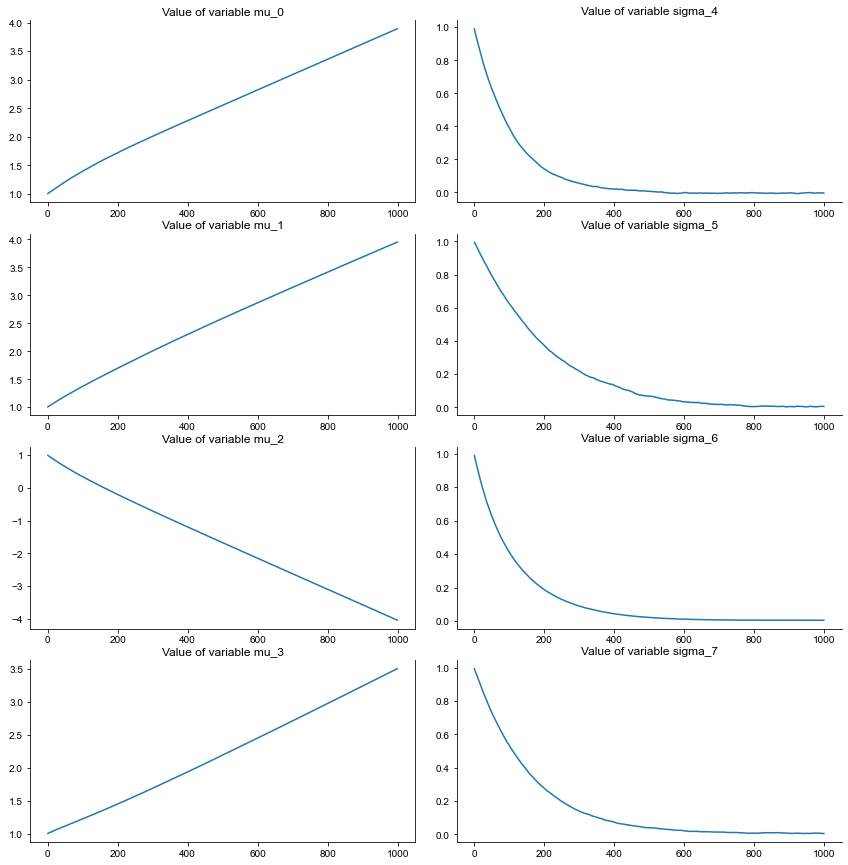

In [17]:
variables_track = bints.var_track
variables_track = variables_track.detach().numpy()
d= bints.d

f,ax = plt.subplots(bints.d,2,figsize=(12,12))
f.tight_layout()

for i in np.arange(2*bints.d):
    
    sns.set_style('whitegrid')
    
    if i < bints.d:
        ax[i,0].plot(variables_track[i,:], label='Value')
        ax[i,0].set_title('Value of variable mu_{}'.format(i))
        ax[i,0].spines["top"].set_visible(False)
        ax[i,0].spines["top"].set_visible(False)
    else:
        ax[i-d,1].plot(variables_track[i,:], label='Value')
        ax[i-d,1].set_title('Value of variable sigma_{}'.format(i))
        ax[i-d,1].spines["right"].set_visible(False)
        ax[i-d,1].spines["top"].set_visible(False)

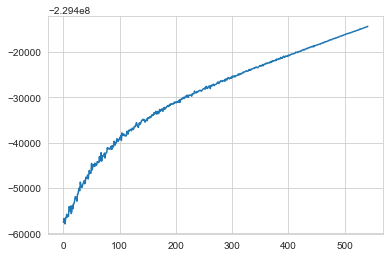

In [18]:
elbo = bints.elbo_track
elbo = elbo.detach().numpy()

plt.plot(elbo)

In [25]:
torch.logdet(torch.randn(4,5,5))

tensor([1.6291,    nan,    nan,    nan])

In [37]:
test_tensor = torch.ones(3,3,3, requires_grad=True)

In [38]:
sum([torch.trace(test_tensor[i,:,:]) for i in [0,1,2]])

tensor(9., grad_fn=<AddBackward0>)